This collab goes over the labelled mechanical turk labels, and we will label the rows with conflicting turk labels.

In [ ]:
from google.colab import drive
import csv
import os
import pandas as pd
import numpy as np

In [ ]:
# Load the Drive helper and mount
# This will prompt for authorization.
drive.mount('/content/drive')

#autenticating to google for google sheets access
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)
# sheet_service = build('sheets', 'v4')

# Note: the path file is hardcoded to the location of the /ethiopia folder in my Google Drive.
FOLDER_PATH = "/content/drive/MyDrive/Projects/Harvest Pile/ethiopia/skysat dataset" #jonathan

# The folder containing the images
INPUT_PATH = FOLDER_PATH + "/"

# To store the labels directly in Google Sheets
# ID of labels_skysat_clip_512_4326_cogs sheet
spreadsheet_id = '19WjvJ9mXsC9vAAaxLiK8yeUzjEz0wij5qWtLss2ixKQ'

Mounted at /content/drive


In [ ]:
turk_df = pd.read_csv(os.path.join(FOLDER_PATH, "turk_results.csv"))

In [ ]:
for col in turk_df.columns:
    print(col)

HITId
HITTypeId
Title
Description
Keywords
Reward
CreationTime
MaxAssignments
RequesterAnnotation
AssignmentDurationInSeconds
AutoApprovalDelayInSeconds
Expiration
NumberOfSimilarHITs
LifetimeInSeconds
AssignmentId
WorkerId
AssignmentStatus
AcceptTime
SubmitTime
AutoApprovalTime
ApprovalTime
RejectionTime
RequesterFeedback
WorkTimeInSeconds
LifetimeApprovalRate
Last30DaysApprovalRate
Last7DaysApprovalRate
Input.filename
Input.lat_1
Input.lon_1
Input.lat_2
Input.lon_2
Input.activity
Input.altitude
Input.lat_mean
Input.lon_mean
Input.year
Input.month
Input.day
Input.image_url
Answer.category.label
Approve
Reject


In [ ]:
turk_df = turk_df[["Input.filename", "Answer.category.label"]]

In [ ]:
turk_df = turk_df.sort_values(by=['Input.filename'])

In [ ]:
turk_df

,Input.filename,Answer.category.label
2333,0.tif,Contains piles
2332,0.tif,Does not contain piles
2347,1.tif,Does not contain piles
2346,1.tif,Contains piles
3194,1000.tif,Contains piles
...,...,...
1681,9983.tif,Contains piles
3188,999.tif,Contains piles
3189,999.tif,Contains piles
1693,9991.tif,Contains piles


In [ ]:
# Create a new column for different row values
turk_df['label_num'] = turk_df.groupby('Input.filename').cumcount() + 1

# Pivot the dataframe to create separate columns for different labels
new_df = turk_df.pivot(index='Input.filename', columns='label_num', values='Answer.category.label').reset_index()

# Rename the columns
new_df.columns = ['filename', 'turk1', 'turk2']

In [ ]:
new_df

,filename,turk1,turk2
0,0.tif,Contains piles,Does not contain piles
1,1.tif,Does not contain piles,Contains piles
2,1000.tif,Contains piles,Does not contain piles
3,10002.tif,Contains piles,Does not contain piles
4,10003.tif,Contains piles,Contains piles
...,...,...,...
3787,998.tif,Does not contain piles,Contains piles
3788,9980.tif,Contains piles,Contains piles
3789,9983.tif,Contains piles,Contains piles
3790,999.tif,Contains piles,Contains piles


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Image
import requests
import math

In [ ]:
new_df = pd.read_csv(os.path.join(FOLDER_PATH, "new_df.csv"))
new_df = new_df.iloc[:, 1:]
diff_df = new_df[new_df["turk1"] != new_df["turk2"]]

In [ ]:
# List of images (replace with your own image paths)

iterator = diff_df.iterrows()
# Create an output widget to display the images
output = widgets.Output()

# Create a button widget
button_next = widgets.Button(description='Next Image')

button_y = widgets.Button(description='yes')
button_n = widgets.Button(description='no')

current_fn = None

def display_next_image(button):
    global current_fn

    try:
        # Get the next row from the iterator
        _, row = next(iterator)
        while not math.isnan(row["activity"]):
          _, row = next(iterator)

        # Clear the output widget
        output.clear_output()

        # Display the current row as a dataframe
        img_num = row["filename"][:-4]
        current_fn = img_num + ".tif"
        img_url = "https://harvestpiles.s3.amazonaws.com/" + img_num + ".png"
        with output:
          display(Image(url=img_url))
          display(img_num)
    except StopIteration:
        # Disable the button if there are no more rows
        button.disabled = True

def label_yes(button):
  new_df.loc[new_df["filename"] == current_fn, "activity"] = 1
  with output:
    display("marked as has activitiy")

def label_no(button):
  new_df.loc[new_df["filename"] == current_fn, "activity"] = 0
  with output:
    display("marked as does not have activitiy")

# Register the button's click event
button_next.on_click(display_next_image)
button_y.on_click(label_yes)
button_n.on_click(label_no)

# Display the button and output widget
display(output)
display(button_next)
display(button_y)
display(button_n)

Output()

Button(description='Next Image', style=ButtonStyle())

Button(description='yes', style=ButtonStyle())

Button(description='no', style=ButtonStyle())

In [ ]:
diff_df

,filename,turk1,turk2,activity
0,0.tif,Contains piles,Does not contain piles,0.0
1,1.tif,Does not contain piles,Contains piles,0.0
2,1000.tif,Contains piles,Does not contain piles,1.0
3,10002.tif,Contains piles,Does not contain piles,0.0
5,10005.tif,Does not contain piles,Contains piles,0.0
...,...,...,...,...
3780,9952.tif,Contains piles,Does not contain piles,NaN
3784,9967.tif,Does not contain piles,Contains piles,NaN
3786,9973.tif,Does not contain piles,Contains piles,NaN
3787,998.tif,Does not contain piles,Contains piles,NaN


In [ ]:
new_df

,filename,turk1,turk2,activity
0,0.tif,Contains piles,Does not contain piles,0.0
1,1.tif,Does not contain piles,Contains piles,0.0
2,1000.tif,Contains piles,Does not contain piles,1.0
3,10002.tif,Contains piles,Does not contain piles,0.0
4,10003.tif,Contains piles,Contains piles,1.0
...,...,...,...,...
3787,998.tif,Does not contain piles,Contains piles,0.0
3788,9980.tif,Contains piles,Contains piles,1.0
3789,9983.tif,Contains piles,Contains piles,1.0
3790,999.tif,Contains piles,Contains piles,1.0


In [ ]:
new_df.loc[new_df["filename"] == "1340.tif", "activity"] = 1

In [ ]:
new_df.loc[(new_df["turk1"] == new_df["turk2"]) & (new_df["turk1"] == "Contains piles"), "activity"] = 1
new_df.loc[(new_df["turk1"] == new_df["turk2"]) & (new_df["turk1"] == "Does not contain piles"), "activity"] = 0

In [ ]:
filtered_df = new_df.loc[new_df["activity"] == 1]

In [ ]:
filtered_df["expert"] = np.nan

<ipython-input-21-fb138baec59c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["expert"] = np.nan


In [ ]:
filtered_df

,filename,turk1,turk2,activity,expert
2,1000.tif,Contains piles,Does not contain piles,1.0,NaN
4,10003.tif,Contains piles,Contains piles,1.0,NaN
6,10021.tif,Does not contain piles,Contains piles,1.0,NaN
7,10028.tif,Contains piles,Contains piles,1.0,NaN
11,10090.tif,Contains piles,Contains piles,1.0,NaN
...,...,...,...,...,...
3783,9964.tif,Contains piles,Contains piles,1.0,NaN
3785,997.tif,Contains piles,Contains piles,1.0,NaN
3788,9980.tif,Contains piles,Contains piles,1.0,NaN
3789,9983.tif,Contains piles,Contains piles,1.0,NaN


In [ ]:
filtered_df.to_csv('out.csv')
!cp "out.csv" "/content/drive/MyDrive/Projects/Harvest Pile/ethiopia/skysat dataset/filtered_df.csv"

In [ ]:
new_df.to_csv('out.csv')

In [ ]:
!cp "out.csv" "/content/drive/MyDrive/Projects/Harvest Pile/ethiopia/skysat dataset/new_df.csv"

# Archive
Old code

This collab will help with the labelling process. The script will:
- find a lat lng point that is not yet covered in our current dataset
- render the photo at that location
- prompt the user to label the photo with a UI
- edit the google sheet in **labels_skysat_clip_512_4326_cogs**

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
import gspread
from google.auth import default

from shapely.geometry import Point, Polygon

from osgeo import gdal
from matplotlib import pyplot as plt
import numpy as np

import ipywidgets as widgets
from IPython.display import display

# Option 1: load df from google Sheets

In [ ]:
#defining my worksheet
worksheet = gc.open("labels_skysat_clip_512_4326_cogs").sheet1

#get_all_values gives a list of rows
rows = worksheet.get_all_values()
#Convert to a DataFrame
df = pd.DataFrame(rows)

#creating columns
df.columns = df.iloc[0]
df = df.iloc[1:]

# Option 2: load df from .csv

In [ ]:
df = pd.read_csv(FOLDER_PATH + "/blue_central.csv")

In [ ]:
df.head()

,Unnamed: 0,filename,lat_1,lon_1,lat_2,lon_2,activity,altitude,lon_mean,lat_mean
0,0,blue_central/20230128_070850_ssc13_u0001_visua...,13.355311,39.057538,13.357625,39.059903,NaN,1671,39.058720,13.356468
1,1,blue_central/20230128_070850_ssc13_u0001_visua...,13.378460,39.057543,13.380774,39.059908,NaN,1589,39.058726,13.379617
2,2,blue_central/20230128_070850_ssc13_u0001_visua...,13.346052,39.057536,13.348366,39.059900,NaN,1662,39.058718,13.347209
3,3,blue_central/20230128_070850_ssc13_u0001_visua...,13.327533,39.057531,13.329847,39.059896,NaN,1617,39.058714,13.328690
4,4,blue_central/20230128_070850_ssc13_u0001_visua...,13.369200,39.057541,13.371515,39.059906,NaN,1681,39.058724,13.370357


In [ ]:
df = df[["filename",	"lat_1",	"lon_1",	"lat_2",	"lon_2",	"activity",	"altitude",	"lon_mean",	"lat_mean"]]

# Sampling and labelling

In [ ]:
labelled_indexes = df.loc[(df['activity'] == '0') | (df['activity'] == '1')].index
labelled_df = df.loc[labelled_indexes]
unlabelled_df = df.loc[df.index.difference(labelled_indexes)]

In [ ]:
len(labelled_indexes)

0

In [ ]:
polygons = []
for _, row in labelled_df.iterrows():
    polygon = Polygon([(row['lon_1'], row['lat_1']),
                       (row['lon_2'], row['lat_1']),
                       (row['lon_2'], row['lat_2']),
                       (row['lon_1'], row['lat_2'])])
    polygons.append(polygon)

In [ ]:
import numpy as np
RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

def get_lat_for_distance(d):
    '''Calculates the degrees latitude for some North-South distance.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees latitude <= returned value

    Args
    - d: numeric, distance in km

    Returns
    - lat: float, approximate degrees latitude
    '''
    lat = d / RADIUS_EARTH  # in radians
    lat = lat * 180.0 / np.pi  # convert to degrees
    return lat
get_lat_for_distance(0.25)

0.0022533432486067737

In [ ]:
# Check if the coordinate is within any of the polygons
def intersects(lon,lat):
  coord = (lon,lat)
  point = Point(coord)
  for polygon in polygons:
      if polygon.buffer(0.002).contains(point): # maybe change to detect collision of 1km circle instead
          return True
          break
  else:
      return False

#111.111 km in the y direction is 1 degree (of latitude) >=

In [ ]:
def load_geotiff(file):
    ds = gdal.Open(file)
    band1 = ds.GetRasterBand(1).ReadAsArray() # Red channel
    band2 = ds.GetRasterBand(2).ReadAsArray() # Green channel
    band3 = ds.GetRasterBand(3).ReadAsArray() # Blue channel
    img = np.dstack((band1, band2, band3))
    return img

Run me to sample:

In [ ]:
def setSheet(idx, val):
  range_name = "F" + str(idx)

  # Update the cell value in the sheet
  value_input_option = 'RAW'
  value_range_body = {
      'range': range_name,
      'values': [[val]],
  }
  request = sheet_service.spreadsheets().values().update(
      spreadsheetId=spreadsheet_id, range=range_name,
      valueInputOption=value_input_option, body=value_range_body)
  response = request.execute()
  print(f'{response.get("updatedCells")} cells updated.')


blue_central/20230128_070816_ssc13_u0001_visual/20230128_070816_ssc13_u0001_visual_0439.tif
Is there harvest activity?


Button(description='Yes', style=ButtonStyle())

Button(description='No', style=ButtonStyle())

Output()

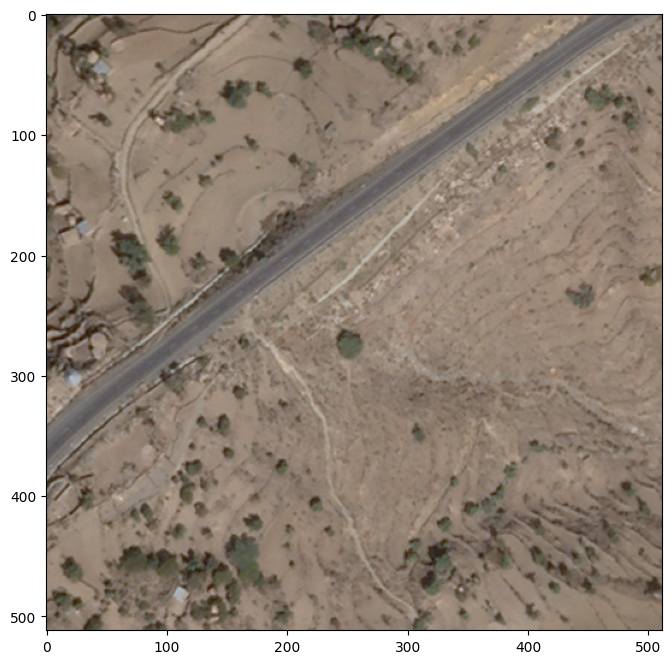

In [ ]:
row = None
found = False

while not found:
  row = unlabelled_df.sample()
  break # TODO: Change back to False to re-enable overlap detection
  lon1 = float(row.iloc[0]["lon_1"])
  lat1 = float(row.iloc[0]["lat_1"])
  lon2 = float(row.iloc[0]["lon_2"])
  lat2 = float(row.iloc[0]["lat_2"])
  within = intersects(lon1, lat1) or intersects(lon2, lat2)
  if not within:
    found = True

image = load_geotiff(INPUT_PATH + "/" + row.iloc[0]["filename"])
print(row.iloc[0]["filename"])
plt.figure(figsize=(8, 8))
plt.imshow(image)


print("Is there harvest activity?")
y_btn = widgets.Button(description="Yes")
n_btn = widgets.Button(description="No")

output = widgets.Output()

display(y_btn, n_btn, output)

def y_button_clicked(b):
  # setSheet(row.index[0] + 1, 1)
  unlabelled_df.drop(index=[row.index[0]], inplace=True)
  df.at[row.index[0], "activity"] = 1
  with output:
    print("Labelled yes.")

def n_button_clicked(b):
  # setSheet(row.index[0] + 1, 0)
  unlabelled_df.drop(index=[row.index[0]], inplace=True)
  df.at[row.index[0], "activity"] = 0
  with output:
    print("Labelled no.")

y_btn.on_click(y_button_clicked)
n_btn.on_click(n_button_clicked)

In [ ]:
len(df[~df['activity'].isnull()])

42

In [ ]:
df.to_csv('out.csv')

In [ ]:
!cp "out.csv" "/content/drive/MyDrive/Projects/Harvest Pile/ethiopia/skysat dataset/blue_central.csv"